Purpose of this notebook - clean datasets, so that GPT-2 with input size of 1024 could learn from them.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
# import nltk
from tqdm import tqdm

sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from src.ds_loaders.cnn_daily import CNNDailyLoader
from src.ds_loaders.ds_loader import DSLoader

In [2]:
cnn_dm_loader = CNNDailyLoader()
cnn_dm_loader.load()

Reusing dataset cnn_dailymail (/home/pasha/.cache/huggingface/datasets/ccdv___cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
def naive_word_counter(s):
    return s.count(" ")


def calc_tokens_n(loader: DSLoader, w_counter=naive_word_counter):
    def calc(X, y, before_str=""):
        # print(before_str)
        res = []
        tq = tqdm(total=len(y))
        for idx, (doc, summ) in enumerate(zip(X, y)):
            # n_words = len(nltk.word_tokenize(doc)) + len(nltk.word_tokenize(summ))
            # n_words = doc.count(" ") + summ.count(" ")
            n_words = w_counter(doc) + w_counter(summ)
            res.append(n_words)
            tq.update()
        return res

    all_res = {
        'train': calc((loader.X_train), (loader.y_train), "Train:"),
        'val': calc((loader.X_val), (loader.y_val), "Validation:"),
        'test': calc((loader.X_test), (loader.y_test), "Test"),
    }

    return all_res


In [4]:
counts = calc_tokens_n(cnn_dm_loader)

100%|██████████| 11490/11490 [00:00<00:00, 94405.24it/s]


In [5]:
def vizualize_n_words_distribution(counts):
    nbins = 10
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    fig.set_figheight(6)
    fig.set_figwidth(20)
    fig.suptitle("Distribution of number of words in document + summary")
    # plt.figure(figsize=(10, 10))
    ax0.hist(counts['train'], bins=nbins)
    ax0.set_title(f"Train")

    # plt.figure(figsize=(10, 10))
    ax1.hist(counts['val'], bins=nbins)
    ax1.set_title(f"Validation")

    # plt.figure(figsize=(10, 10))
    ax2.hist(counts['test'], bins=nbins)
    ax2.set_title(f"Test")
    pass

# plt.figure(figsize=(10, 10))
# plt.hist(counts['train'], bins=8)
# plt.title(f"Distribution of train number of words in document + summary")

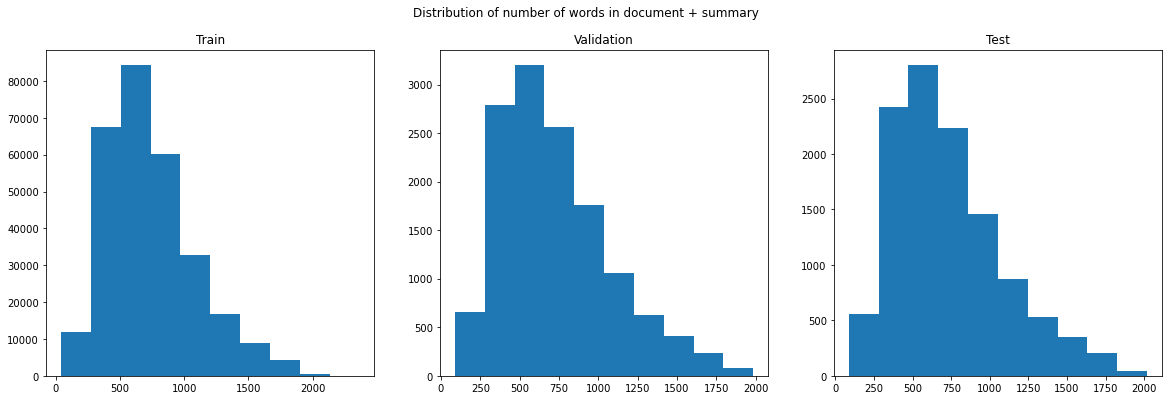

In [6]:
vizualize_n_words_distribution(counts)

In [7]:
def smaller_1024_perc(counts):
    print(
        f"Percentage of n_words(doc+sum)<1024 in train: {round(len((np.where((np.asarray(counts['train']) <= 1024))[0])) / len(counts['train']) * 100, 3)}%")
    print(
        f"Percentage of n_words(doc+sum)<1024 in val: {round(len((np.where((np.asarray(counts['val']) <= 1024))[0])) / len(counts['val']) * 100, 3)}%")
    print(
        f"Percentage of n_words(doc+sum)<1024 in test: {round(len((np.where((np.asarray(counts['test']) <= 1024))[0])) / len(counts['test']) * 100, 3)}%")

In [8]:
smaller_1024_perc(counts)

Percentage of n_words(doc+sum)<1024 in train: 81.411%
Percentage of n_words(doc+sum)<1024 in val: 81.373%
Percentage of n_words(doc+sum)<1024 in test: 81.097%


In [9]:
# print(cnn_dm_loader.X_train[0])

In [10]:
# Firstly save all, sine later dependency datasets breaks everything
import json


def ds_filter_to_json(loader, path="ds.json", predicate=lambda k, idx: True, ):
    def _sub_part(X, y, pred):
        res = []
        tq = tqdm(total=len(y))
        for idx, (doc, summ) in enumerate(zip(X, y)):
            # if pred(X[idx], y[idx]):
            if pred(idx):
                res.append({
                    'document': doc,
                    'summary': summ
                })
                tq.update()
        return res

    res = {
        'train': _sub_part(loader.X_train, loader.y_train, lambda idx: predicate('train', idx)),
        'val': _sub_part(loader.X_val, loader.y_val, lambda idx: predicate('val', idx)),
        'test': _sub_part(loader.X_test, loader.y_test, lambda idx: predicate('test', idx)),
    }
    with open(path, 'w') as f:
        json.dump(res, f, indent=4)


In [18]:
ds_filter_to_json(cnn_dm_loader, "../../data/cnn_daily_full.json")

100%|██████████| 11490/11490 [00:00<00:00, 1043083.70it/s]


In [11]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens = {'pad_token': '<|pad|>', 'sep_token': '<|sep|>'}
num_add_toks = tokenizer.add_special_tokens(special_tokens)

In [13]:
# print(len(tokenizer.encode(cnn_dm_loader.X_train[0])))
# print(cnn_dm_loader.X_train[0].count(" "))

def gpt2_tokenizer_less_1024(doc, summ):
    return (len(tokenizer.encode(doc)) + len(tokenizer.encode(summ))) < 1024


def gpt2_count_pred_1024(s):
    # return len(tokenizer.encode(s)) < 1024
    return len(tokenizer.encode(s))


In [15]:
gpt2_counts = calc_tokens_n(cnn_dm_loader, gpt2_count_pred_1024)


100%|██████████| 11490/11490 [00:43<00:00, 267.16it/s]


In [ ]:
vizualize_n_words_distribution(gpt2_counts)

In [27]:
smaller_1024_perc(gpt2_counts)
# print(f"Percentage of n_words(doc+sum)<1024 in train: {round((np.sum((np.asarray(gpt2_counts['train']) == 2))) / len(counts['train']) * 100, 3)}%")
# print(f"Percentage of n_words(doc+sum)<1024 in val: {round((np.sum((np.asarray(gpt2_counts['val']) == 2))) / len(counts['val']) * 100, 3)}%")
# print(f"Percentage of n_words(doc+sum)<1024 in test: {round((np.sum((np.asarray(gpt2_counts['test']) == 2))) / len(counts['test']) * 100, 3)}%")


2
Percentage of n_words(doc+sum)<1024 in train: 70.031%
Percentage of n_words(doc+sum)<1024 in val: 71.29%
Percentage of n_words(doc+sum)<1024 in test: 70.853%


In [31]:
# ds_filter_to_json(cnn_dm_loader, "../../data/cnn_daily_tok.json", predicate=lambda k, idx: gpt2_counts[k][idx] == 2)
ds_filter_to_json(cnn_dm_loader, "../../data/cnn_daily_tok.json", predicate=lambda k, idx: gpt2_counts[k][idx] < 1024)


 70%|███████   | 201067/287113 [00:00<00:00, 958219.99it/s]

 71%|███████▏  | 9530/13368 [00:00<00:00, 949920.79it/s]

 71%|███████   | 8141/11490 [00:00<00:00, 694825.89it/s]


Tokenize

In [19]:
def gpt2_tokenize_save_1024(loader, path: str):
    CLIP_IDX = 1000

    def _sub_tokenize(X, y):
        res = []
        # tq = tqdm(total=len(y))
        k = 0
        tq = tqdm(total=CLIP_IDX)
        for idx, (doc, summ) in enumerate(zip(X, y)):

            if k >= CLIP_IDX:
                return res

            doc_tok = tokenizer.encode(doc)
            summ_tok = tokenizer.encode(summ)
            if len(doc_tok) + len(summ_tok) + 1 > 1024:
                continue
            res.append(
                {
                    'document': doc_tok,
                    'summary': summ_tok,
                }
            )
            k += 1
            tq.update()
        return res

    res = {
        'train': _sub_tokenize(loader.X_train, loader.y_train),
        'val': _sub_tokenize(loader.X_val, loader.y_val),
        'test': _sub_tokenize(loader.X_test, loader.y_test),
    }
    with open(path, 'w') as f:
        json.dump(res, f, indent=4)

In [20]:
gpt2_tokenize_save_1024(cnn_dm_loader, "../../data/cnn_daily_1024_tok_clip_1000.json")


100%|██████████| 1000/1000 [00:05<00:00, 169.44it/s][A

100%|██████████| 1000/1000 [00:05<00:00, 188.79it/s][A

100%|██████████| 1000/1000 [00:05<00:00, 196.24it/s][A


In [24]:
tokenizer = GPT2Tokenizer.from_pretrained('sshleifer/tiny-gpt2')
special_tokens = {'pad_token': '<|pad|>', 'sep_token': '<|sep|>'}
tokenizer.add_special_tokens(special_tokens)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

2

In [25]:
gpt2_tokenize_save_1024(cnn_dm_loader, "../../data/cnn_daily_1024_tok_clip_1000_tiny_gpt2.json")


  0%|          | 0/1000 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1879 > 1024). Running this sequence through the model will result in indexing errors

100%|██████████| 1000/1000 [00:06<00:00, 145.11it/s][A

100%|██████████| 1000/1000 [00:05<00:00, 182.57it/s][A

100%|██████████| 1000/1000 [00:05<00:00, 197.23it/s]
